In [1]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab2/data/'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab2/data/'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
cat.10000.jpg  hr-train.npy   mnist	   res-test.npy   vgg-train.npy
CatDog	       inc.pt	      model.ckpt   res-train.npy
hr.pt	       inc-test.npy   models.ckpt  vgg.pt
hr-test.npy    inc-train.npy  res.pt	   vgg-test.npy


In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [0]:
#Task, now using the cat/dog dataset. 
#1. Define your own network by following presented network now with sigmoid output
#2. Using your cat/dog dataset, train the model
#3. Visualize the filter and intermediate convolved channel (any channel)
import os

default_directory = os.path.join(myDrive, 'CatDog/train')

class CatDog(torch.utils.data.Dataset):
    
    def __init__(self, transform, *, dataDir = default_directory):
        #Initialize the data and label list
        self.labels = []
        self.data = []
        
        #First load all images data
        listImage = os.listdir(dataDir)
        
        for x in listImage:
            #Second filter according name for labelling : cat : 1, dog : 0
            lbl = 1 if 'cat' in x else 0
            # Append to our class attribute :)
            path = os.path.join(dataDir, x)
            self.data.append(path)
            self.labels.append(lbl)
        
        
    def __getitem__(self, index):
        img = Image.open(self.data[index])
        img = transform(img)
        return img, self.labels[index]
    

    def __len__(self):
        return len(self.data)

# !Task 2, make three transforms in order : resize to (128,128), to tensor, normalize with mean and std = (.5,.5,.5)
tr = []  #
tr.append(T.Resize((128, 128)))
tr.append(T.ToTensor())
tr.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[.5, .5, .5]))
transform = T.Compose(tr)

In [0]:
#! Task one, complete your network 
class ConvNetSig(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        default_num_filters = 32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, default_num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(default_num_filters, default_num_filters, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(131072, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        #dont forget to reshape your output of CNN to be one vector
        #ex : out.reshape(out.size(0), -1)
        out = self.conv1(x)
        out = out.reshape(out.size(0), -1)
        #print(out.size())
        out = self.fc(out)
        return out
        


In [8]:
CNNS = ConvNetSig()
CNNS = CNNS.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(CNNS.parameters(), lr = learning_rate)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(CNNS):,} trainable parameters')

# Device configuration
num_epochs = 10


#training
#! Task two, train your model

#! instantiate the dataset class and the loader
CatDogTrain =  CatDog(transform=transform)
train_loader = torch.utils.data.DataLoader(CatDogTrain, batch_size=64, shuffle=True)

print(len(CatDogTrain))

loss_training = []

if True:
    print('training')
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            out = CNNS(images.to(device))
            loss = criterion(out, labels.to(device))
            optimizer.zero_grad()
            loss.backward()
            loss_training.append(loss.item())
            optimizer.step()
        print('Epoch: ' +str(epoch)+ ' trained!' )
    # Save the model checkpoint
    torch.save(CNNS.state_dict(), 'models.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))
    
CNNS.load_state_dict(torch.load('models.ckpt'))


The model has 272,290 trainable parameters
7500
training


KeyboardInterrupt: ignored

In [0]:
#! Task three, test your model
if True : 
    #! define your test loader
    CDTest = CatDog('./CatDog/t_s/')
    test_loader =torch.utils.data.DataLoader(CDTest, batch_size=64, shuffle=True)
    
    CNNS.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    
    loss_test = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = CNNS(images)
            loss = criterion(outputs, labels.to(device))
            loss_test.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
            
        print('Correct classified: ' + str(correct))
        print('Total tested images: ' + str(total))
        print('Accuracy of the model: {} %'.format(accuracy))



Correct classified: 7140
Total tested images: 7500
Accuracy of the model: 95.2 %


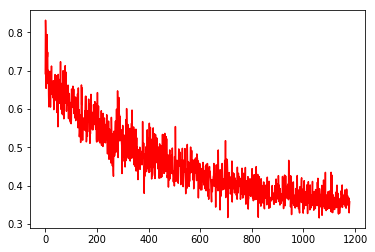

In [0]:
# Loss during the training
plt.plot(loss_training, 'r')
plt.show()

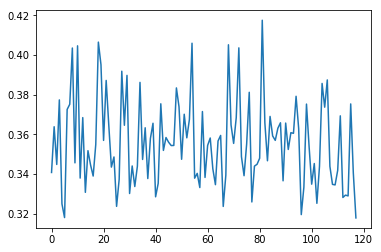

In [0]:
# Loss during the testing
plt.plot(loss_test)
plt.show()

Weights Shapes
(32, 3, 3, 3)
(32, 32, 3, 3)
(3, 3)

 First filter


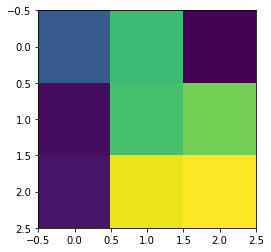


 32 filters


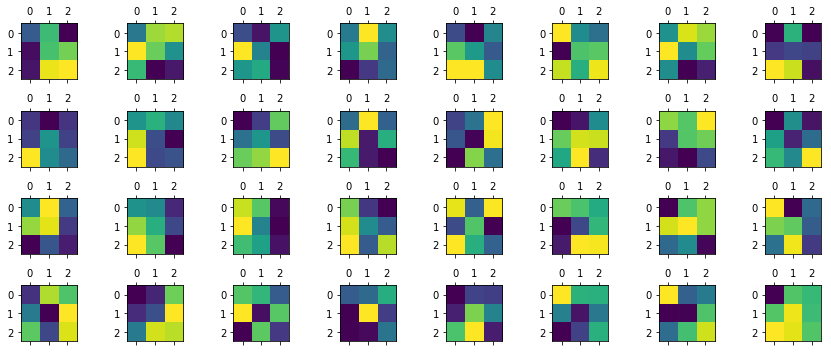

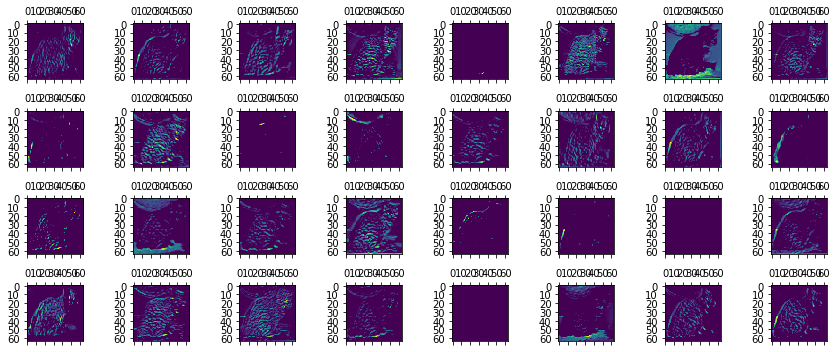

In [0]:
#! Task four, visualize the filter and internal channel
 #visualize filter
weight1 = CNNS.conv1[0].weight.data.cpu().numpy()
weight2 = CNNS.conv1[2].weight.data.cpu().numpy()

print('Weights Shapes')
print(weight1.shape)
print(weight2.shape)

f11 = weight1[0,0]
print(f11.shape)
print('\n First filter')
plt.imshow(f11)
plt.show()

print('\n 32 filters')
fig = plt.figure(figsize=(12,5))
#Plot all filter
for i in range(32):
    axt = fig.add_subplot(4, 8, i+1)
    plt.matshow(weight1[i,0],fignum=False)
plt.tight_layout()
plt.show()

imgTest = next(iter(test_loader))[0][0].cuda()
CNNS.to(device)
imgInter = CNNS.conv1(imgTest.unsqueeze(0)).squeeze(0).detach().cpu().numpy()


fig = plt.figure(figsize=(12,5))
#Plot all filter
for i in range(32):
    axt = fig.add_subplot(4, 8, i+1)
    plt.matshow(imgInter[i],fignum=False)
plt.tight_layout()
plt.show()